### play game func

In [8]:
import numpy as np
import torch
from board import Board
from model import ConnectFourNN

def select_action(state, model:ConnectFourNN, epsilon):
    """
    Returns: col, reward\n
    a move chosen with eps-greedy policy and punishment for illegal moves 
    """
    reward = 0
    if np.random.rand() < epsilon:
        valid_moves = []
        for i in range(state.shape[1]):
            if state[0][i] == 0:
                valid_moves.append(i)
        return np.random.choice(valid_moves), reward
    else:
        with torch.no_grad():
            model.eval()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            action_sorted = model(state_tensor).argsort(descending=True)
            for col in action_sorted[0]:
                if state[0][col] == 0:
                    return col, reward
                reward -= 0.15

def play_exp_game(yellow_model, red_model, eps) -> tuple:
    """
    # Returns:
    2 lists of experiences - yellow, red
    """

    board = Board()
    start_player = 1
    curr_player = start_player
    done = False

    states = []
    actions = []
    rewards = []
    next_states = []

    while not done:
        if curr_player == 1:
            main_model = yellow_model
        elif curr_player == 2:
            main_model = red_model

        state = board.pieces.copy()
        action, action_reward = select_action(state = state, model = main_model, epsilon = eps)
        next_state, board_reward, done = board.drop_piece(action, curr_player)
        reward = action_reward + board_reward

        # update previous player if he lost or drew
        if board_reward == board.win_reward:
            rewards[-1] += -board.win_reward
        elif board_reward == board.draw_reward:
            rewards[-1] += board.draw_reward

        next_states.append(next_state)
        actions.append(action)
        rewards.append(reward)
        states.append(state)

        curr_player = 3 - curr_player

    yellow_exp_list, red_exp_list = [], []
    for i in range(len(rewards)):
        if not i%2:
            yellow_exp_list.append((states[i], actions[i], rewards[i], next_states[i]))
        else:
            red_exp_list.append((states[i], actions[i], rewards[i], next_states[i]))

    return yellow_exp_list, red_exp_list


def play_eval_game(model, test_model, mask_moves = False) -> int:
    """
    mask_moves: bool
     if `True` model is allowed to choose valid action\n
     if `False` model loses when choosing invalid action 
    # Returns:
    `1` - model win \n
    `0` - draw \n
    `-1` - test_model win \n
    """
    
    board = Board()
    start_player = 1
    curr_player = start_player
    done = False

    while True:
        if curr_player == 1:
            curr_model = model
        elif curr_player == 2:
            curr_model = model

        with torch.no_grad():
            curr_model.eval()
            action_sorted = curr_model(board.state).argsort(descending=True)
            if mask_moves:
                for col in action_sorted[0]:
                    if board.is_valid_move(col):
                        _, reward, _ = board.drop_piece()
                    if not mask_moves:
                        return -1 if curr_model == model else 1

        if reward == board.win_reward:
            return 1 if curr_model == model else -1
        elif reward == -board.win_reward:
            return 1 if curr_model == model else -1
        elif reward == board.draw_reward:
            return 0
                
        curr_player = 3 - curr_player

SyntaxError: expected ':' (3989137190.py, line 116)

### Train step func

In [2]:
import random
import torch.nn as nn

def train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class):
    if len(replay_buffer) < batch_size:
        return 0
    
    main_model.train()

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states = zip(*batch)

    states = torch.tensor(np.array(states), dtype=torch.float32).unsqueeze(1)
    actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).unsqueeze(1)

    q_values = main_model(states).gather(1, actions).squeeze()

    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + gamma * next_q_values * (rewards == 0)

    loss = loss_class()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach().numpy()

# Hyper Parameters

In [3]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.01
eps_decay = 0.99995
epochs = 10**5
batch_size = 64
train_freq = 1
target_update_freq = 50
checkpoint_freq = 10**4
gamma = 0.98
lr = 3e-3

# TODO TEST OTHER
# loss_class = nn.MSELoss
loss_class = nn.HuberLoss


# Initialize Models

In [4]:
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

"""
player 1 - yellow
player 2 - red
"""

def initialize_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# YELLOW INIT

yellow_main_model = ConnectFourNN()
yellow_main_model.apply(initialize_weights_he)

yellow_target_model = ConnectFourNN()
yellow_target_model.load_state_dict(yellow_main_model.state_dict())
yellow_target_model.eval()

yellow_replay_buffer = ReplayBuffer()

yellow_optimizer = optim.Adam(yellow_main_model.parameters(), lr = lr)


# RED INIT

red_main_model = ConnectFourNN()
red_main_model.apply(initialize_weights_he)

red_target_model = ConnectFourNN()
red_target_model.load_state_dict(red_main_model.state_dict())
red_target_model.eval()

red_replay_buffer = ReplayBuffer()

red_optimizer = optim.Adam(red_main_model.parameters(), lr = lr)

# Training Loop

  0%|          | 0/100000 [00:00<?, ?it/s]c:\Users\cp\anaconda3\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 100000/100000 [6:50:00<00:00,  4.07it/s]  


Text(0.5, 1.0, 'lr=3e-03 eps_decay=0.99995 f_t=1 f_c=50 bs=64')

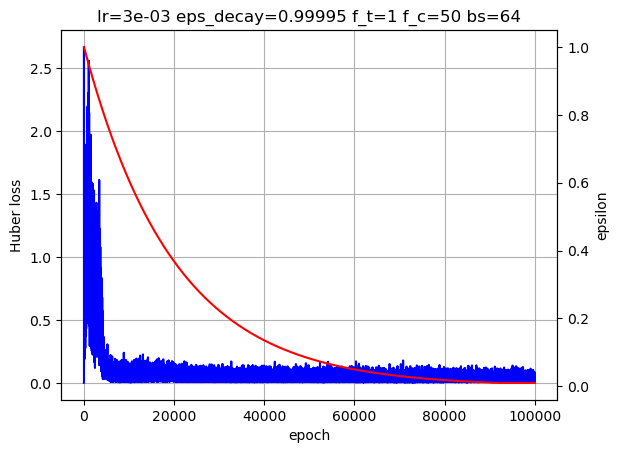

In [5]:
from datetime import datetime
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

losses = []
times = []
EPS = []

for t in tqdm(range(epochs)):
    yellow_experience, red_experience = play_exp_game(yellow_main_model, red_main_model, eps)
    
    yellow_replay_buffer.extend(yellow_experience)
    red_replay_buffer.extend(red_experience)

    if not t % train_freq:
        loss = train_step(yellow_main_model, yellow_target_model, yellow_optimizer, yellow_replay_buffer, gamma, batch_size, loss_class)
        loss = train_step(red_main_model, red_target_model, red_optimizer, red_replay_buffer, gamma, batch_size, loss_class)

        times.append(t)
        losses.append(loss)
        EPS.append(eps)

    if not t % target_update_freq:
        yellow_target_model.load_state_dict(yellow_main_model.state_dict())
        red_target_model.load_state_dict(red_main_model.state_dict())

    if not t % checkpoint_freq and t != 0:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        yellow_path = rf'models/yel_cp{t//checkpoint_freq}_{stamp}.pth'
        red_path = rf'models/red_cp{t//checkpoint_freq}_{stamp}.pth'
        torch.save(yellow_main_model, yellow_path)
        torch.save(red_main_model, red_path)

    eps = max(eps_min, eps_decay * eps)

plt.plot(times, losses, 'b-')
plt.xlabel("epoch")
plt.ylabel("Huber loss")
plt.grid()
ax2 = plt.twinx()
ax2.plot(times, EPS, 'r-')
ax2.set_ylabel('epsilon')
plt.title(f'lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')


In [6]:
y, r = play_exp_game(yellow_main_model, red_main_model, eps=0)
for i in y:
    print(i[2])

# yellow_replay_buffer.extend(y)
# red_replay_buffer.extend(r)

0
0
0
0
0
0
0
0
0
0
0
0
0
-1
